https://www.hfbrasil.org.br/br/estatistica/batata.aspx

https://cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx


In [1]:
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import batelada as bt
import scipy as sp
# https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

figsize = (20, 10)


In [2]:
def testes_normalidade(resid):
    print("D'Agostino's K-squared test")
    print(sp.stats.normaltest(resid))
    print('Kolmogorov-Smirnov test')
    print(sp.stats.kstest(resid, 'norm'))
    print('Lilliefors test')
    print(sm.stats.diagnostic.lilliefors(resid, dist='norm', pvalmethod='table'))
    print('Shapiro-Wilk test')
    print(sp.stats.shapiro(resid))
    

In [3]:
def plot_resid(t, resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.lineplot(x=t, y=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Erro")
    plt.grid()
    plt.show()
    plt.close()


In [4]:
def ked_resid(resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.kdeplot(x=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(
        f"""{title}
    Média 1: {(resid).mean():.3}
    Desvio 1: {(resid).std():.3}"""
    )
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Erro")
    plt.ylabel("KDE")
    plt.grid()
    plt.show()
    plt.close()


In [5]:
def plot_serie(t, y, yest, title):
    # Plota a figura
    plt.figure(figsize = figsize)
    sns.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
    sns.lineplot(x=t,y=yest,color='red',linestyle='-',label='Um passo a frente')
    plt.title(title)
    plt.legend(labels=["Real","Um passo a frente"])
    plt.xlabel('Amostra')
    plt.ylabel('Saída')
    plt.grid()
    plt.show()
    plt.close()


# Batata


## Pré-processamento dos dados


In [6]:
df_batata = pd.read_excel("20221001214857-precos-medios-batata.xlsx")
df_batata = pl.DataFrame(df_batata)
date_batata = df_batata.select(
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=pl.col("Dia")).alias("Data")
)
df_batata = df_batata.with_column(date_batata.to_series())


In [7]:
df_agata = df_batata.filter(
    (pl.col("Produto") == "Padrão agata primeira - beneficiador")
    & (pl.col("Unidade") == "saco 50 kg")
    & (pl.col("Data").is_between(pl.datetime(2008, 1, 1), pl.datetime(2020, 12, 31)))
).select(["Data", "Preço", "Ano", "Mês"])


df_agata = (
    df_agata.groupby(["Ano", "Mês"])
    .agg(
        [
            pl.col("Preço").mean().alias("Preço médio"),
            pl.col("Preço").std().alias("Preço desvio"),
            pl.col("Preço").min().alias("Preço menor"),
            pl.col("Preço").max().alias("Preço maior"),
        ]
    )
    .select(
        [
            pl.all(),
            pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=1).alias("Data"),
        ]
    )
    .sort("Data")
)

df_agata = df_agata.upsample("Data", "1mo").interpolate().fill_null("forward")


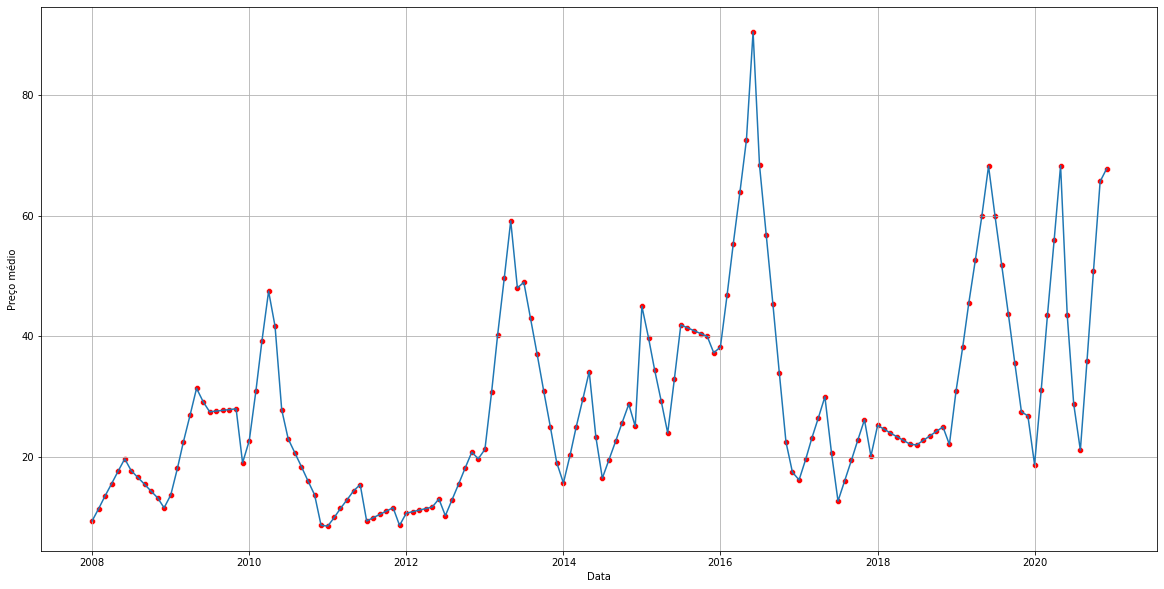

In [8]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_agata.to_pandas(), x="Data", y="Preço médio")
sns.scatterplot(data=df_agata.to_pandas(), x="Data", y="Preço médio", color="red")
plt.grid()
plt.show()
plt.close()


## Modelo AR


In [9]:
# Importa um arquivo com os dados de saída
data = df_agata.select(["Mês", "Preço médio"]).to_numpy()

print("Método dos mínimos quadrados em batelada")
u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")


Método dos mínimos quadrados em batelada
Número de pontos: 156


In [10]:
na, nb = 3, 0
delay = 0
yest_1, yest_n, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y - yest_1) ** 2) / (npts - deep)

print(f"MSE 1: {MSE_1:0.2f}")
t = np.arange(y.size)


MSE 1: 0.16


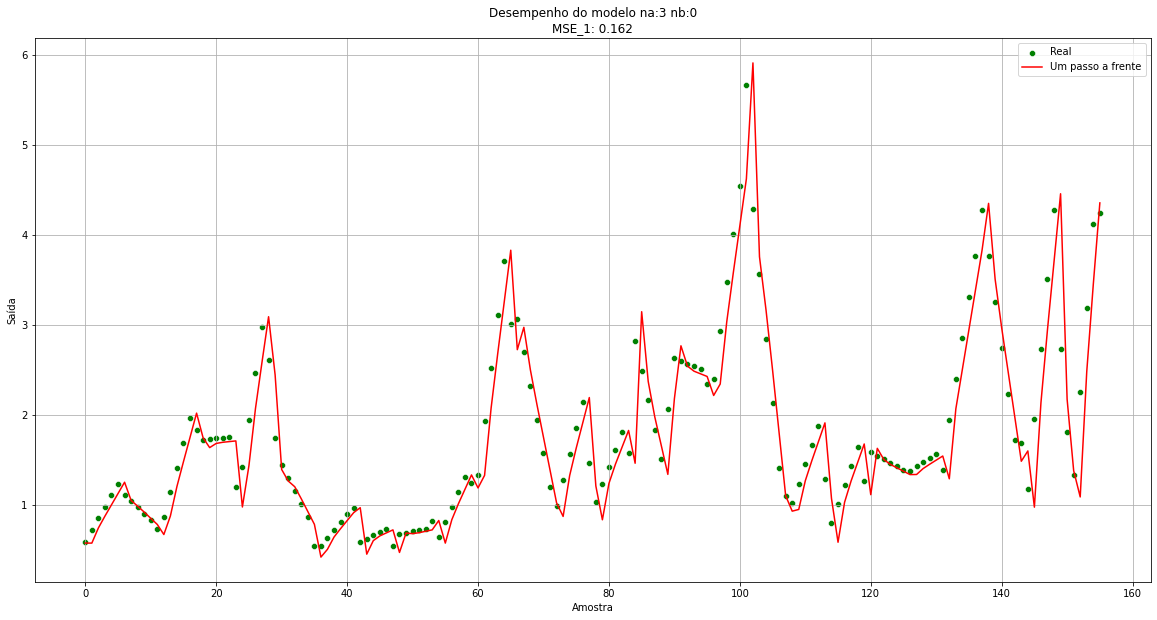

In [11]:
title = f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1:.3}'
plot_serie(t, y, yest_1, title)

In [12]:
resid = y-yest_1
testes_normalidade(resid)

D'Agostino's K-squared test
NormaltestResult(statistic=35.29810071886683, pvalue=2.1632903753055884e-08)
Kolmogorov-Smirnov test
KstestResult(statistic=0.28171996365220553, pvalue=1.910986187902116e-11)
Lilliefors test
(0.09923349377681057, 0.0018067206198010756)
Shapiro-Wilk test
ShapiroResult(statistic=0.9226043224334717, pvalue=1.9969907327777037e-07)


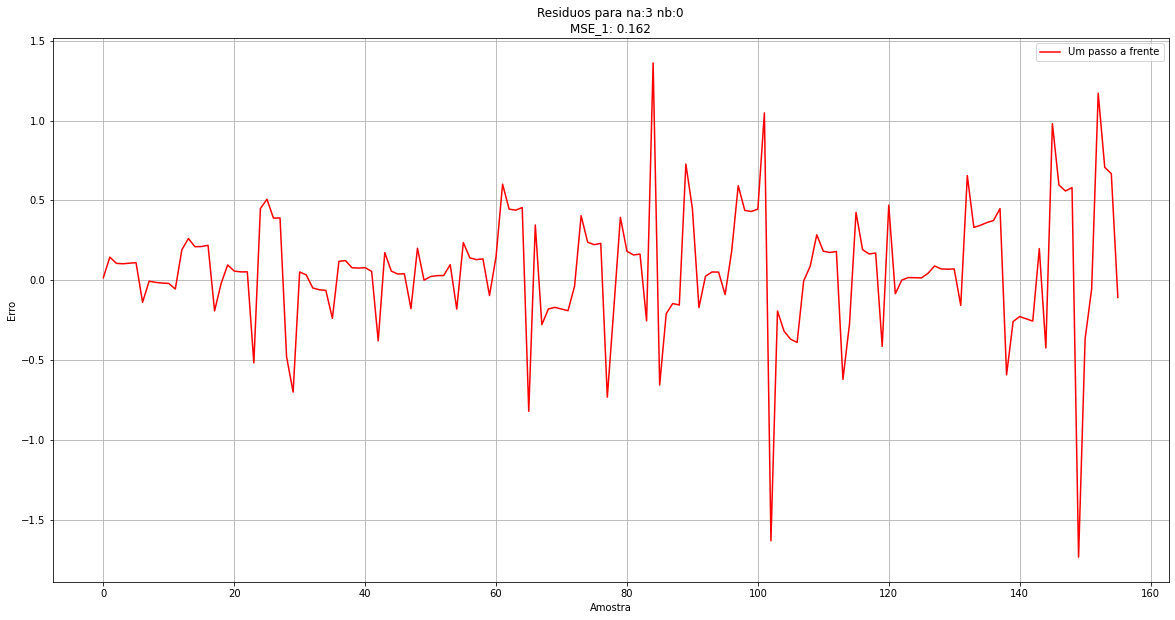

In [13]:
title = f"Residuos para na:{na} nb:{nb}\nMSE_1: {MSE_1:.3}"
plot_resid(t, resid, title)

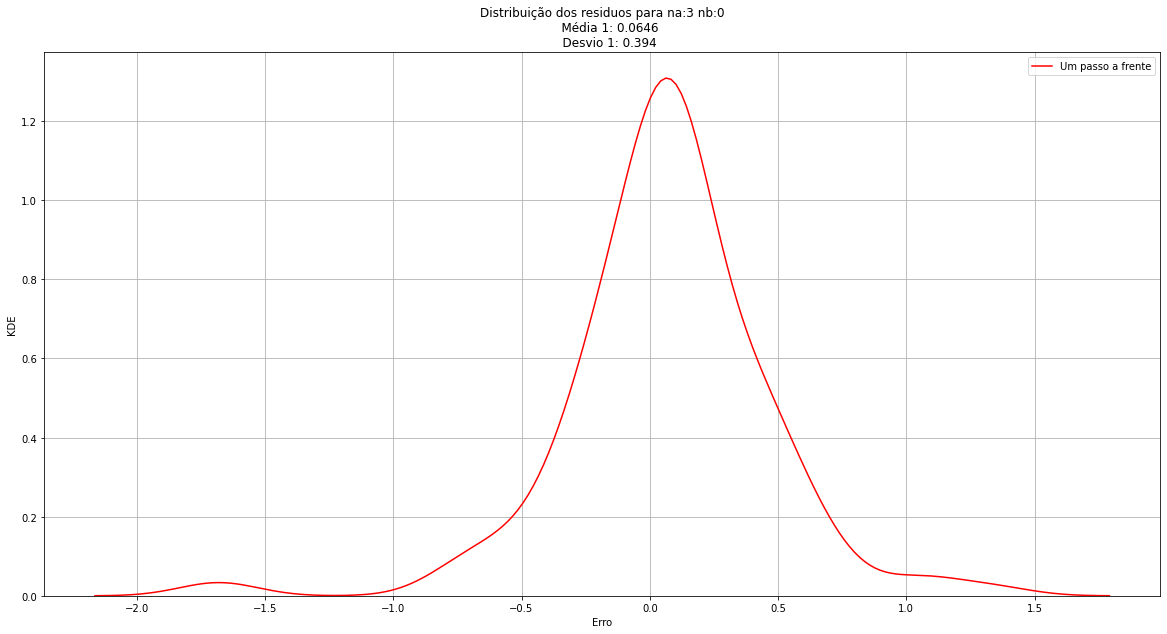

In [14]:
title = f"Distribuição dos residuos para na:{na} nb:{nb}"
ked_resid(resid, title)


## Modelo ARMA


In [15]:
arma = ARIMA(endog=y, order=(3, 3, 0)).fit()
resid = arma.resid
arma.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:                 ARIMA(3, 3, 0)   Log Likelihood                -132.404
Date:                Thu, 13 Oct 2022   AIC                            272.808
Time:                        20:30:52   BIC                            284.930
Sample:                             0   HQIC                           277.732
                                - 156                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8658      0.057    -15.221      0.000      -0.977      -0.754
ar.L2         -0.4741      0.075     -6.353      0.000      -0.620      -0.328
ar.L3         -0.1759      0.076     -2.302      0.021      -0.326      -0.026
sigma2         0.3288      0.021     15.386      0.000       0.287       0.371
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               198.22
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               4.15   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

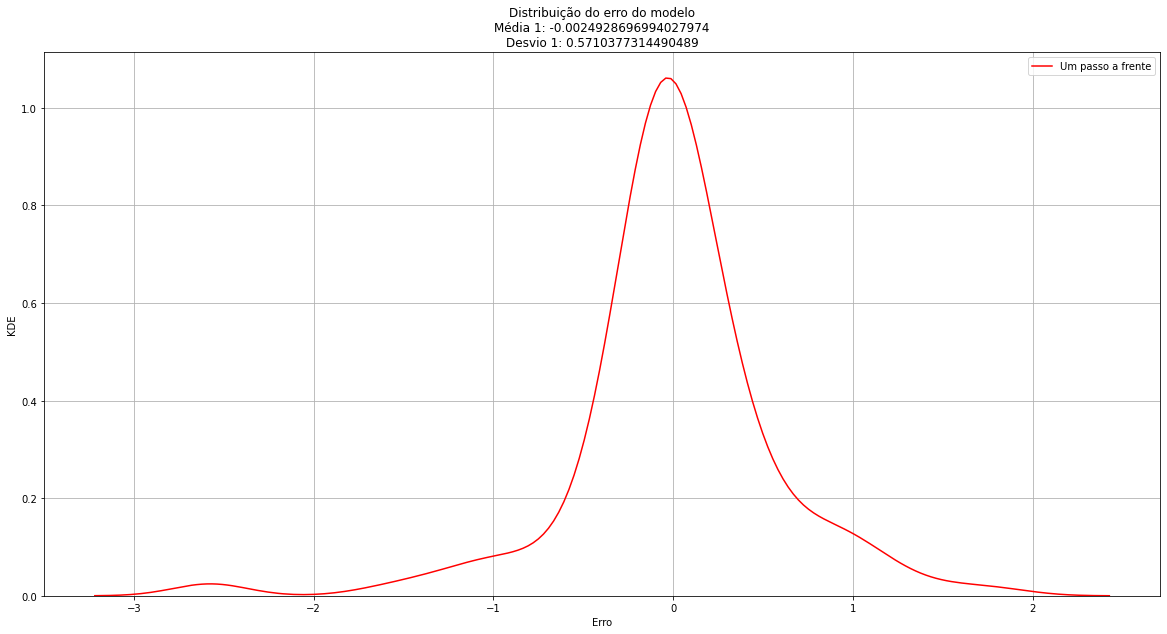

In [16]:
# Plota a figura
plt.figure(figsize=figsize)
sns.kdeplot(x=resid, color="red", linestyle="-", label="Um passo a frente")
plt.title(
    f"""Distribuição do erro do modelo
Média 1: {(resid).mean()}
Desvio 1: {(resid).std()}"""
)
plt.legend(labels=["Um passo a frente"])
plt.xlabel("Erro")
plt.ylabel("KDE")
plt.grid()
plt.show()
plt.close()


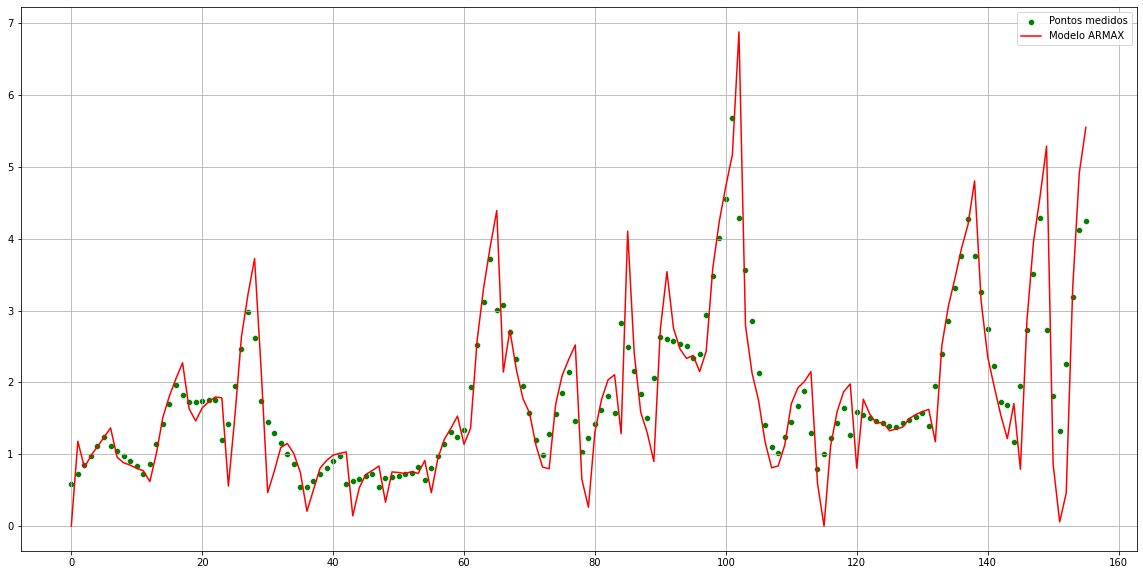

In [17]:
plt.figure(figsize=figsize)
sns.scatterplot(x=t, y=y, color="green", markers=".", label="Pontos medidos")
res = arma.predict()
sns.lineplot(x=t, y=res, color="red", label="Modelo ARMAX")
plt.grid()
plt.show()
plt.close()


# Leite


## Pré-processamento


In [18]:
df_leite = pd.read_excel("cepea-consulta-20221001213951-leite.xls")
df_leite = pl.DataFrame(df_leite)
columns = df_leite.columns[1:]
columns = [
    df_leite[c].str.replace(",", ".").str.replace("-", "NaN").apply(float).alias(c)
    for c in columns
]
df_leite = df_leite.with_columns(columns)
df_leite = df_leite.with_column(
    ("01/" + pl.col("Data")).str.strptime(pl.Date, fmt="%d/%m/%Y").alias("Data")
)
df_leite = df_leite.select(
    [pl.col("Data"), pl.col("Preço líquido médio").alias("Preço")]
)


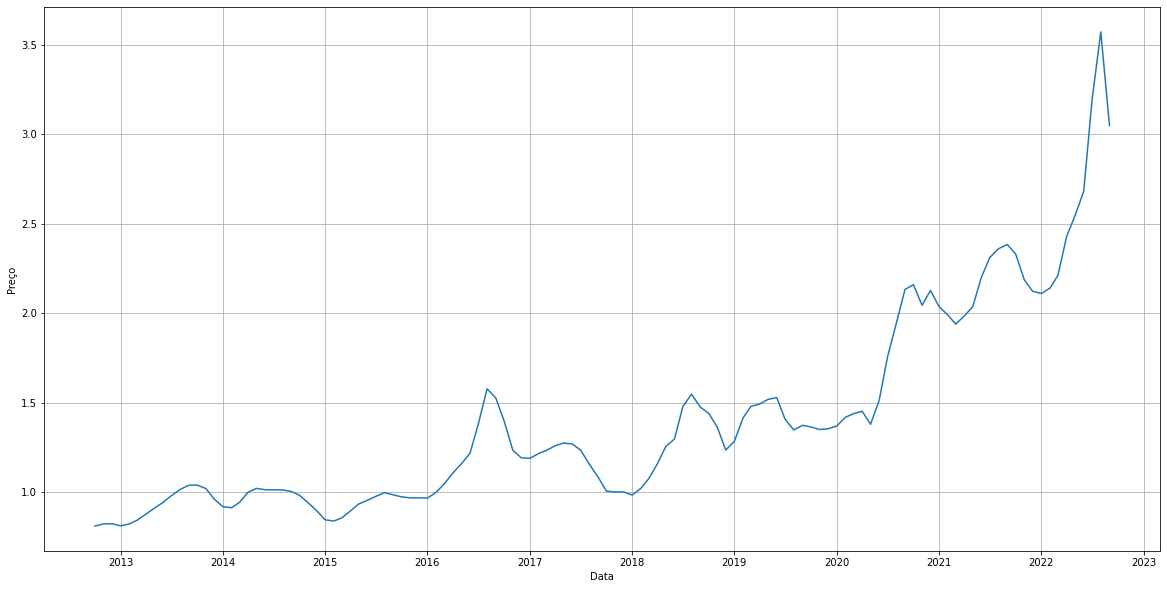

In [19]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_leite.to_pandas(), x="Data", y="Preço")
plt.grid()
plt.show()
plt.close()


## ARX


In [20]:
# Importa um arquivo com os dados de saída
data = df_leite.select([pl.col("Data").dt.month(), "Preço"]).to_numpy()


In [21]:
print("Método dos mínimos quadrados em batelada")
u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo de LS precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")


Método dos mínimos quadrados em batelada
Número de pontos: 120


In [22]:
na, nb = 3, 0
delay = 0
yest_1, yest_n, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y - yest_1) ** 2) / (npts - deep)

print(f"MSE 1: {MSE_1:0.2f}")
t = np.arange(y.size)


MSE 1: 0.03


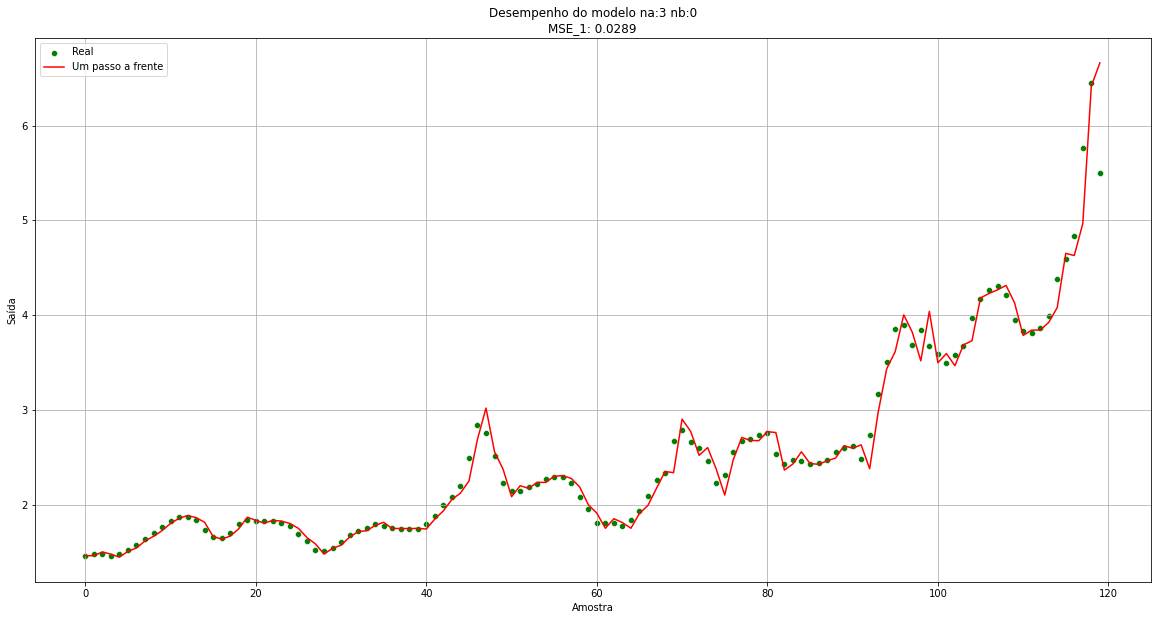

In [23]:
title = f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1:.3}'
plot_serie(t, y, yest_1, title)


In [24]:
resid = y-yest_1
testes_normalidade(resid)

D'Agostino's K-squared test
NormaltestResult(statistic=85.62831105293031, pvalue=2.5471147307328913e-19)
Kolmogorov-Smirnov test
KstestResult(statistic=0.3982507447339736, pvalue=1.10698485679656e-17)
Lilliefors test
(0.19856571770420084, 0.0009999999999998899)
Shapiro-Wilk test
ShapiroResult(statistic=0.7028815746307373, pvalue=2.9050421329569406e-14)


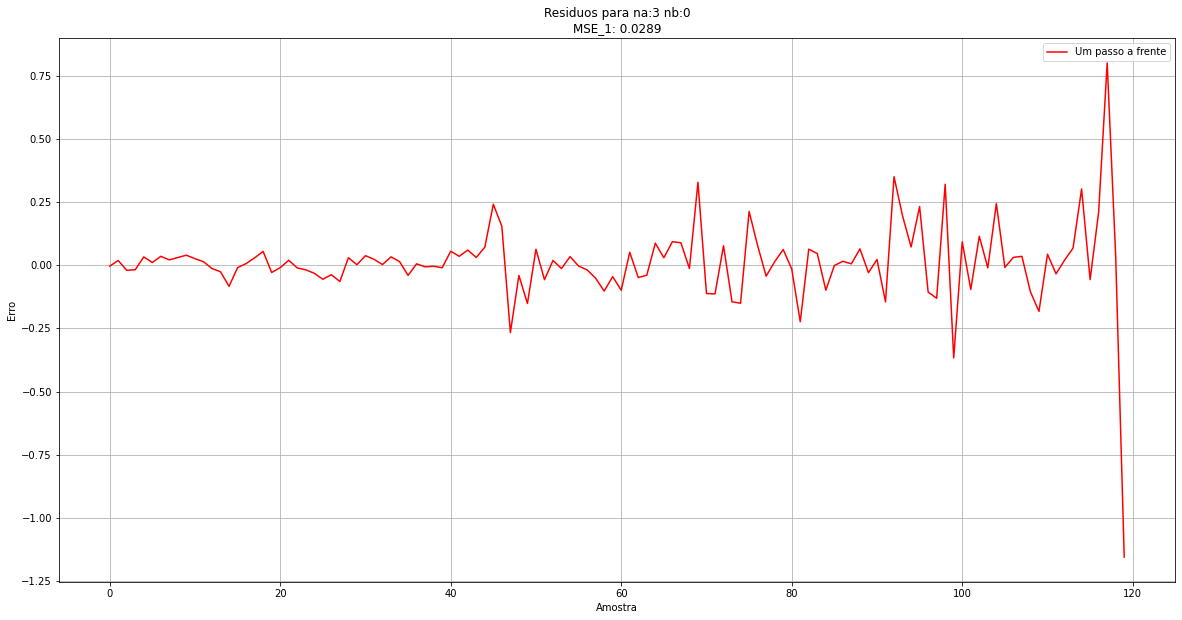

In [25]:
title = f"Residuos para na:{na} nb:{nb}\nMSE_1: {MSE_1:.3}"
plot_resid(t, resid, title)


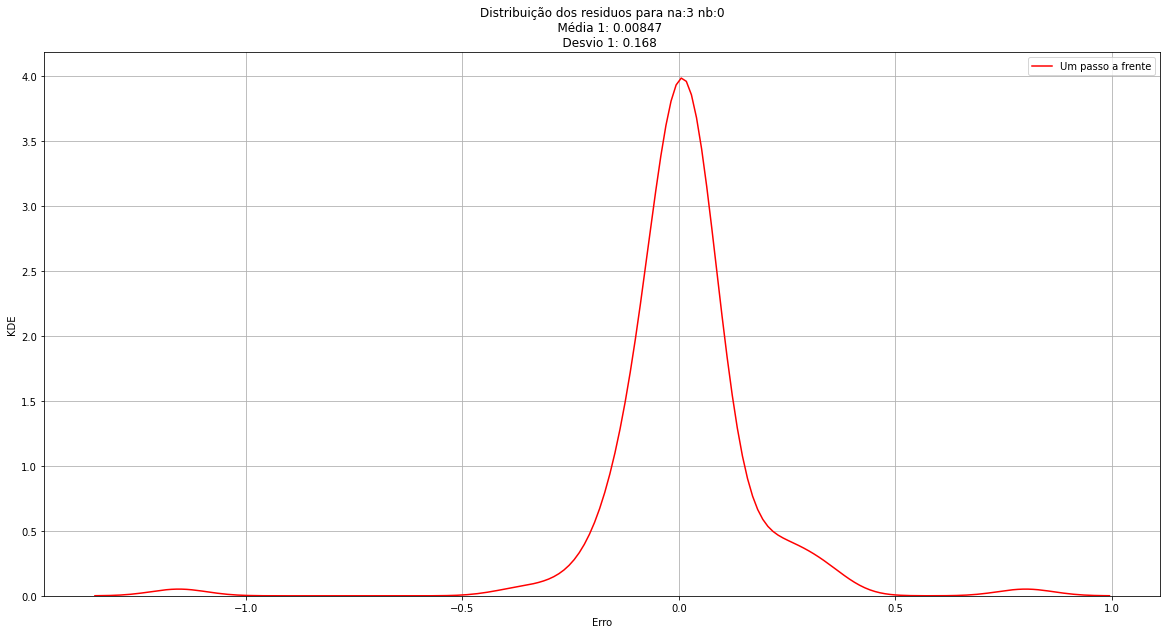

In [26]:
title = f"Distribuição dos residuos para na:{na} nb:{nb}"
ked_resid(resid, title)


## Modelo ARMA


In [27]:
arma = ARIMA(endog=y, order=(3, 3, 0)).fit()
resid = arma.resid
mse = arma.mse

In [28]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                 ARIMA(3, 3, 0)   Log Likelihood                  16.057
Date:                Thu, 13 Oct 2022   AIC                            -24.114
Time:                        20:30:53   BIC                            -13.065
Sample:                             0   HQIC                           -19.629
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5890      0.100     -5.916      0.000      -0.784      -0.394
ar.L2         -0.8034      0.120     -6.671      0.000      -1.039      -0.567
ar.L3         -0.2943      0.133     -2.208      0.027      -0.556      -0.033
sigma2         0.0439      0.004     12.389      0.000       0.037       0.051
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               955.42
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              48.41   Skew:                            -2.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

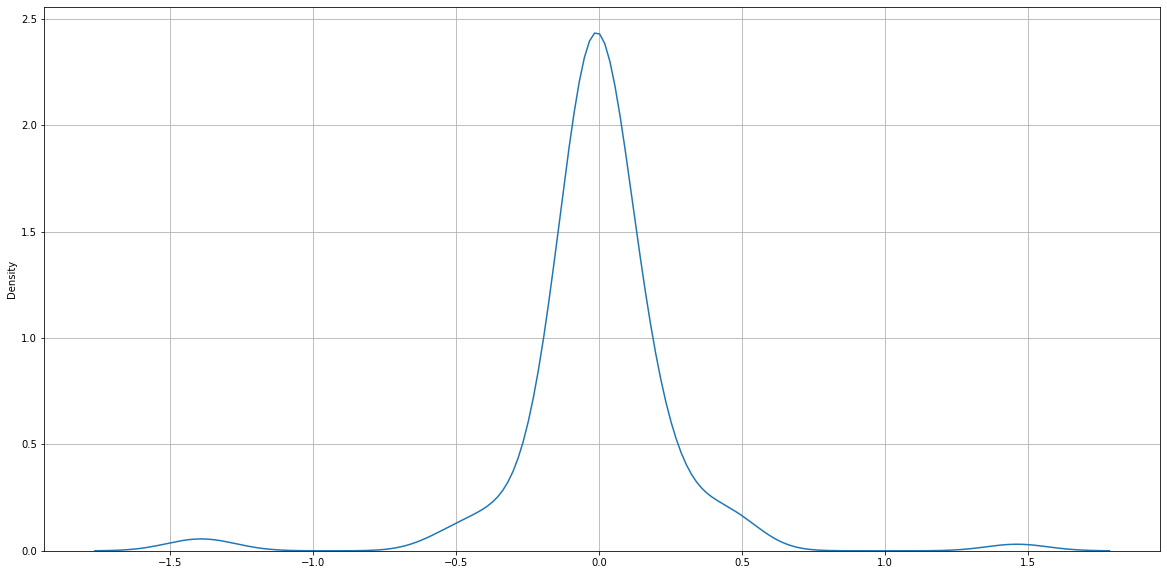

In [29]:
plt.figure(figsize=figsize)
sns.kdeplot(resid)
plt.grid()
plt.show()
plt.close()


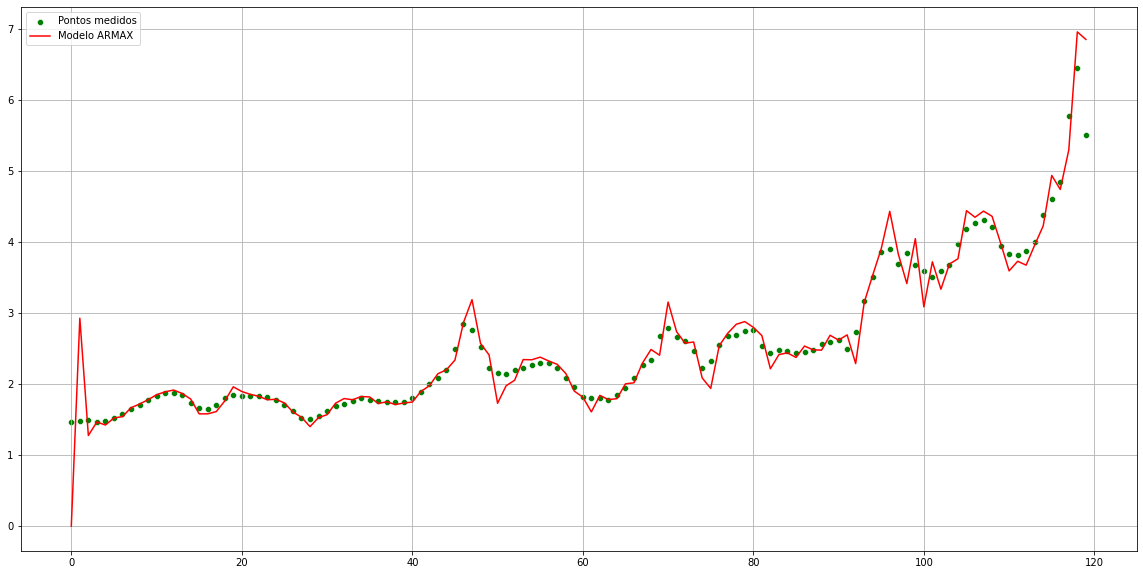

In [30]:
plt.figure(figsize=figsize)
sns.scatterplot(x=t, y=y, color="green", markers=".", label="Pontos medidos")
res = arma.predict()
sns.lineplot(x=t, y=res, color="red", label="Modelo ARMAX")
plt.grid()
plt.show()
plt.close()
